In [1]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
from sklearn.metrics import pairwise
import pandas as pd
from sklearn import preprocessing

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1600])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1600])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    #data.degree = 4
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

In [5]:
#RANDOM_SELECTION(1)

# SVM-RFE

In [6]:
@time_func
def SVM_RFE_W_STEP(mode = 'const', step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=3):
    data.kernel = kernel
    #data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    kf = KFold(n_splits=7, shuffle=True)

    if mode == 'const':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe, index)
    if mode == 'dyn':
        index = [(train_index, test_index, percentage, 1) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_dynamic_step, index)

    #scores = list(map(data.svm_rfe_dynamic_step, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(mode, C, step)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

In [7]:
#SVM_RFE_W_STEP('const', C=0.000001, step=10, kernel='liblinear')

dyn 1e-06 10


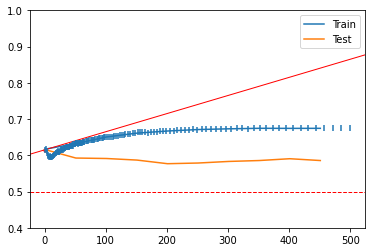

AT (1, 0.6156138161998884, 0.3079089470400893) WITH 140 ITERATIONS IN 2.125132049833025 SECONDS : 0.002729027450502089
__main__.SVM_RFE_W_STEP - 00:00:05.003808700


((1, 0.6156138161998884, 0.3079089470400893), 2.125132049833025)

In [8]:
SVM_RFE_W_STEP('dyn', C=0.000001, percentage=0.03, kernel='liblinear')

dyn 0.6 10


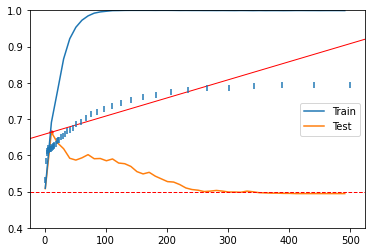

AT (11, 0.6637746112004903, 0.2733803110396078) WITH 45 ITERATIONS IN 2.774503435407366 SECONDS : 0.006500712757842012
__main__.SVM_RFE_W_STEP - 00:01:24.709699100


((11, 0.6637746112004903, 0.2733803110396078), 2.774503435407366)

In [13]:
SVM_RFE_W_STEP('dyn', C=0.60, percentage=0.12, kernel='poly')

const 0.6 500


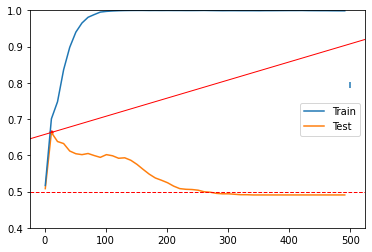

AT (11, 0.6631152116098106, 0.2739078307121516) WITH 1 ITERATIONS IN 0.3484302248273577 SECONDS : 0.0009906676897297967
__main__.SVM_RFE_W_STEP - 00:01:20.612326300


((11, 0.6631152116098106, 0.2739078307121516), 0.3484302248273577)

In [14]:
SVM_RFE_W_STEP('const', C=0.60, step=500, kernel='poly')

In [10]:
#model_selection = {}
#for step in [2, 10, 50]:
#    for C in [0.000001, 0.00001, 0.0001, 0.001, 0.01]:
#        model_selection[C, step] = SVM_RFE_W_STEP('const', C=C, step=step)

In [11]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {2: 1, 10: 2, 50: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

NameError: name 'model_selection' is not defined

In [18]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {2: 1, 10: 2, 50: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000001} & 0:03.691 & 0:00.643 & 0:00.124\\
\textbf{0.000010} & 0:05.242 & 0:01.050 & 0:00.190\\
\textbf{0.000100} & 0:07.001 & 0:01.440 & 0:00.279\\
\textbf{0.001000} & 0:08.039 & 0:01.522 & 0:00.334\\
\textbf{0.010000} & 0:11.834 & 0:02.424 & 0:00.577\\


dyn 1e-06 10


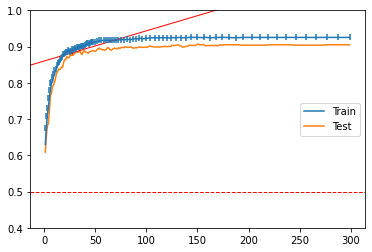

AT (26, 0.8819560720969173, 0.11176847565579952) WITH 98 ITERATIONS IN 1.0480911391122 SECONDS : 0.0010376737357648603
__main__.SVM_RFE_W_STEP - 00:00:11.451224800
dyn 1e-05 10


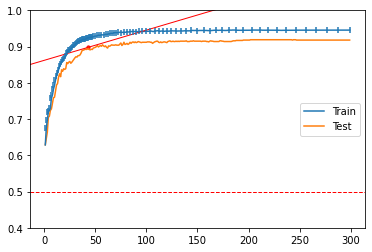

AT (43, 0.897989334609053, 0.11027519897942432) WITH 98 ITERATIONS IN 1.4555052348545618 SECONDS : 0.0025133572058662975
__main__.SVM_RFE_W_STEP - 00:00:14.737496900
dyn 0.0001 10


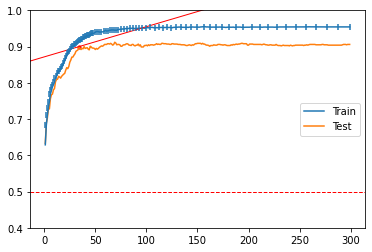

AT (34, 0.8999873366070551, 0.10267679738102259) WITH 98 ITERATIONS IN 1.9477909292493547 SECONDS : 0.0069522666806557136
__main__.SVM_RFE_W_STEP - 00:00:19.727042600
dyn 0.001 10


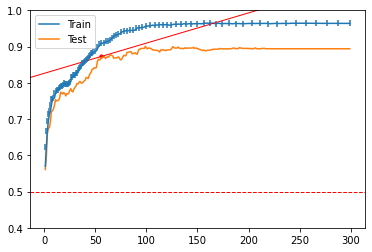

AT (56, 0.8729580278876055, 0.13896691102324898) WITH 98 ITERATIONS IN 2.5057989188602994 SECONDS : 0.008802123880706616
__main__.SVM_RFE_W_STEP - 00:00:21.128434400
dyn 0.01 10


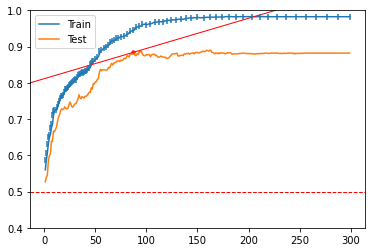

AT (87, 0.8840103558413418, 0.15079171532692656) WITH 98 ITERATIONS IN 3.487846783229283 SECONDS : 0.03582113319837576
__main__.SVM_RFE_W_STEP - 00:00:31.562596900
dyn 1e-06 10


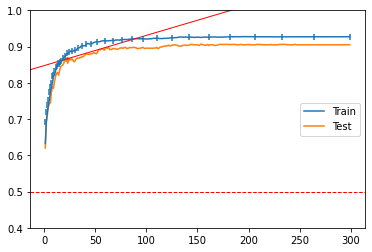

AT (22, 0.8660142674227181, 0.12185525272849215) WITH 41 ITERATIONS IN 0.3243836334773472 SECONDS : 0.00038518267626609393
__main__.SVM_RFE_W_STEP - 00:00:10.777978300
dyn 1e-05 10


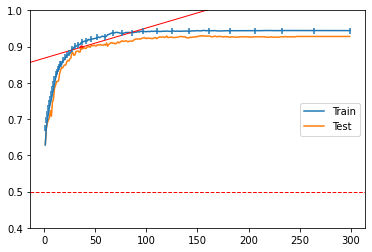

AT (36, 0.8980385811371727, 0.10556913509026183) WITH 41 ITERATIONS IN 0.4435204097202846 SECONDS : 0.0005986436571781584
__main__.SVM_RFE_W_STEP - 00:00:13.877235400
dyn 0.0001 10


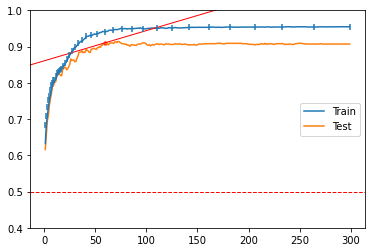

AT (59, 0.9100265931251846, 0.11131205883318562) WITH 41 ITERATIONS IN 0.6124327182769775 SECONDS : 0.0012514452844568172
__main__.SVM_RFE_W_STEP - 00:00:17.429158200
dyn 0.001 10


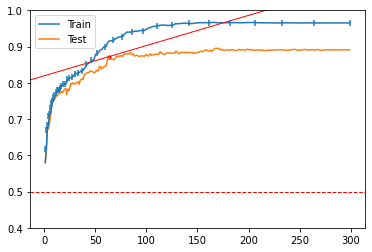

AT (63, 0.8720223438533299, 0.1443821249173361) WITH 41 ITERATIONS IN 0.7091366563524518 SECONDS : 0.0012579494249509982
__main__.SVM_RFE_W_STEP - 00:00:19.355449800
dyn 0.01 10


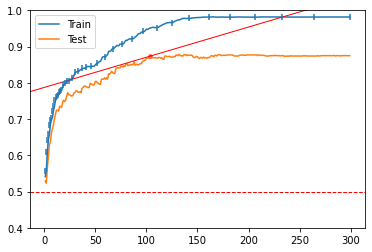

AT (104, 0.8739992401964232, 0.17013394117619482) WITH 41 ITERATIONS IN 1.079563856124878 SECONDS : 0.00447713864022197
__main__.SVM_RFE_W_STEP - 00:00:28.256007300
dyn 1e-06 10


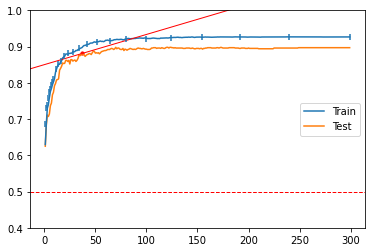

AT (37, 0.8809992824077331, 0.11986724074048022) WITH 26 ITERATIONS IN 0.20228733335222518 SECONDS : 7.167152677436894e-05
__main__.SVM_RFE_W_STEP - 00:00:11.384991000
dyn 1e-05 10


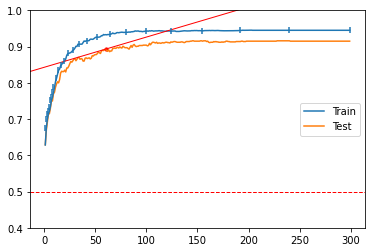

AT (60, 0.8929732239591394, 0.1256214208326885) WITH 26 ITERATIONS IN 0.28303228105817524 SECONDS : 7.294638295689412e-05
__main__.SVM_RFE_W_STEP - 00:00:14.857164500
dyn 0.0001 10


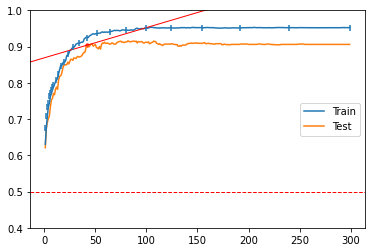

AT (42, 0.9040255519128758, 0.10477955846969936) WITH 26 ITERATIONS IN 0.3805417673928397 SECONDS : 0.0003573543008384632
__main__.SVM_RFE_W_STEP - 00:00:18.456455900
dyn 0.001 10


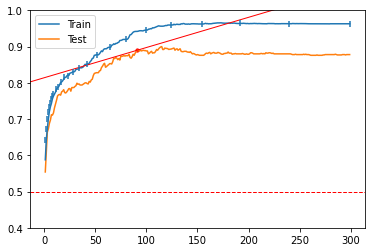

AT (91, 0.8899691857438337, 0.14869131807159974) WITH 26 ITERATIONS IN 0.4048577036176409 SECONDS : 0.0004987775106869498
__main__.SVM_RFE_W_STEP - 00:00:19.062885500
dyn 0.01 10


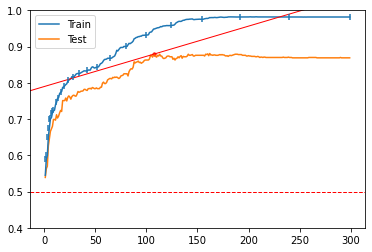

AT (107, 0.8789872099731255, 0.16814356535483294) WITH 26 ITERATIONS IN 0.6391521521977016 SECONDS : 0.0005886251985374451
__main__.SVM_RFE_W_STEP - 00:00:27.763447600


In [19]:
model_selection = {}
for step in [0.04, 0.12, 0.20]:
    for C in [0.000001, 0.00001, 0.0001, 0.001, 0.01]:
        model_selection[C, step] = SVM_RFE_W_STEP('dyn', C=C, percentage=step)

In [20]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.04: 1, 0.12: 2, 0.20: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000001} &    26 & 88.20\% & 0.112 &    22 & 86.60\% & 0.122 &    37 & 88.10\% & 0.120\\
\textbf{0.000010} &    43 & 89.80\% & 0.110 &    36 & 89.80\% & 0.106 &    60 & 89.30\% & 0.126\\
\textbf{0.000100} &    34 & 90.00\% & 0.103 &    59 & 91.00\% & 0.111 &    42 & 90.40\% & 0.105\\
\textbf{0.001000} &    56 & 87.30\% & 0.139 &    63 & 87.20\% & 0.144 &    91 & 89.00\% & 0.149\\
\textbf{0.010000} &    87 & 88.40\% & 0.151 &   104 & 87.40\% & 0.170 &   107 & 87.90\% & 0.168\\


In [21]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.04: 1, 0.12: 2, 0.20: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000001} & 0:01.048 & 0:00.324 & 0:00.202\\
\textbf{0.000010} & 0:01.455 & 0:00.443 & 0:00.283\\
\textbf{0.000100} & 0:01.947 & 0:00.612 & 0:00.380\\
\textbf{0.001000} & 0:02.505 & 0:00.709 & 0:00.404\\
\textbf{0.010000} & 0:03.487 & 0:01.079 & 0:00.639\\
